In [26]:
import scanpy as sc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import sys, pathlib
repo_root = pathlib.Path('./st-celltype-deconvolution/src/models').resolve()
sys.path.insert(0, str(repo_root))

from vae_sc import VAE, vae_loss, compute_uncertainty
from uncertainty_gcn import UncertaintyGCN, compute_loss
from gcn_claude import ImprovedUncertaintyGCN, improved_loss

In [27]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

# ================== 1. 读取数据 ==================
scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
ST = sc.read_h5ad("../scvi-tools-DestVI/data/st_lymph_node_preprocessed.h5ad")
# 统一基因集并一致归一化（scRNA 与 ST 必须使用同一 gene set 和相同变换）
genes = scRNA.var_names.intersection(ST.var_names)
scRNA = scRNA[:, genes].copy()
ST = ST[:, genes].copy()

# 统一归一化策略（两端都用 total-count normalization + log1p）
def _is_log_transformed(adata):
    X = adata.X
    if hasattr(X, "A"): X = X.A
    arr = np.asarray(X)
    if arr.size == 0:
        return False
    if np.nanmax(arr) > 100:
        return False
    return True

for name, ad in (("scRNA", scRNA), ("ST", ST)):
    # 先检查当前 ad.X（不要先覆盖它）
    X_curr = ad.X.A if hasattr(ad.X, "A") else ad.X
    print(f"{name}: current ad.X max={np.nanmax(X_curr):.4f}")
    if _is_log_transformed(ad):
        print(f"{name}: appears already log-transformed, skipping normalize/log1p (max={np.nanmax(X_curr):.4f})")
        # 保留原有 ad.X，不做覆盖
    else:
        # 只有在 ad.X 看起来是 raw counts 时才取 counts layer 或 ad.X 做归一+log1p
        mat = ad.layers["counts"] if "counts" in ad.layers else ad.X
        mat = mat.A if hasattr(mat, "A") else mat
        ad.layers["norm_counts"] = mat  # 保留原始稀疏/原始 counts
        ad.X = ad.layers["norm_counts"]  # 现在 ad.X 是 raw counts，下面做 normalize+log1p
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        print(f"{name}: applied normalize_total + log1p (new max={np.nanmax(ad.X):.4f})")

# 现在再取 X_sc, X_st 并转成 numpy / torch
if "counts" in scRNA.layers:
    X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
else:
    X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X

if "counts" in ST.layers:
    X_st = ST.X.A if hasattr(ST.X, "A") else ST.X
else:
    X_st = ST.X.A if hasattr(ST.X, "A") else ST.X

# 最后转 torch 并送到 device
X_sc = torch.tensor(np.asarray(X_sc), dtype=torch.float32).to(device)
X_st = torch.tensor(np.asarray(X_st), dtype=torch.float32).to(device)
labels = scRNA.obs["broad_cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)
# debug 打印，强制断言维度一致
print("genes count:", len(genes))
print("X_sc.shape:", X_sc.shape, "X_st.shape:", X_st.shape)
# ...existing code...

celltypes = scRNA.obs["broad_cell_types"].astype("category").cat.categories.tolist()

使用设备: cuda
scRNA: current ad.X max=11.3014
scRNA: appears already log-transformed, skipping normalize/log1p (max=11.3014)
ST: current ad.X max=7.7890
ST: appears already log-transformed, skipping normalize/log1p (max=7.7890)
genes count: 1888
X_sc.shape: torch.Size([14989, 1888]) X_st.shape: torch.Size([1092, 1888])


In [28]:
def train_vae_with_scheduling(vae, dataloader, num_epochs=100, device="cpu"):
    """带学习率调度和早停的VAE训练"""
    vae = vae.to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
    )
    
    best_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    # 逐步增加KL权重
    # beta_start, beta_end = 0.0001, 0.01
    # beta_schedule = np.linspace(beta_start, beta_end, num_epochs//2)
    
    for epoch in range(num_epochs):
        vae.train()
        epoch_loss = 0
        
        # 设置当前beta值
        # beta = beta_end if epoch >= len(beta_schedule) else beta_schedule[epoch]
        beta = 0.001
        
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            
            dec_mu, dec_theta, dec_pi, mu, logvar = vae(x_batch)
            loss, zinb, kl = vae_loss(x_batch, dec_mu, dec_theta, dec_pi, mu, logvar, beta=beta)
            
            loss.backward()
            # 梯度裁剪防止爆炸
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Beta: {beta:.6f}")
        
        # 验证并调整学习率
        scheduler.step(avg_loss)
        
        # 早停
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(vae.state_dict(), "best_vae_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    # 加载最佳模型
    vae.load_state_dict(torch.load("best_vae_model.pt"))
    return vae

In [29]:

dataset = TensorDataset(X_sc, labels)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型
n_genes = X_sc.shape[1]
hidden_dims = [512, 256]
latent_dim = 32
vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 训练VAE（使用优化的训练函数）
vae = train_vae_with_scheduling(
    vae=vae,
    dataloader=dataloader,
    num_epochs=100,  # 可根据需要调整
    device=device
)

# 计算细胞类型不确定性
# n_types = len(celltypes)
# sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
# RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
#     vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
# )

# # 归一化细胞类型不确定性作为GCN的输入
# type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
# print("细胞类型不确定性:", type_unc)

# # 可视化不确定性
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(type_unc)), type_unc)
# plt.xticks(range(len(type_unc)), celltypes, rotation=90)
# plt.title("每种细胞类型的不确定性")
# plt.tight_layout()
# plt.show()

Epoch 1/100, Loss: 0.5664, Beta: 0.001000
Epoch 11/100, Loss: 0.4747, Beta: 0.001000
Epoch 21/100, Loss: 0.4684, Beta: 0.001000
Epoch 31/100, Loss: 0.4662, Beta: 0.001000
Epoch 41/100, Loss: 0.4636, Beta: 0.001000
Epoch 51/100, Loss: 0.4634, Beta: 0.001000
Epoch 61/100, Loss: 0.4627, Beta: 0.001000
Epoch 71/100, Loss: 0.4624, Beta: 0.001000
Epoch 81/100, Loss: 0.4604, Beta: 0.001000
Epoch 91/100, Loss: 0.4589, Beta: 0.001000


直接加载模型版

/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2637806/415758575.py:54: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.

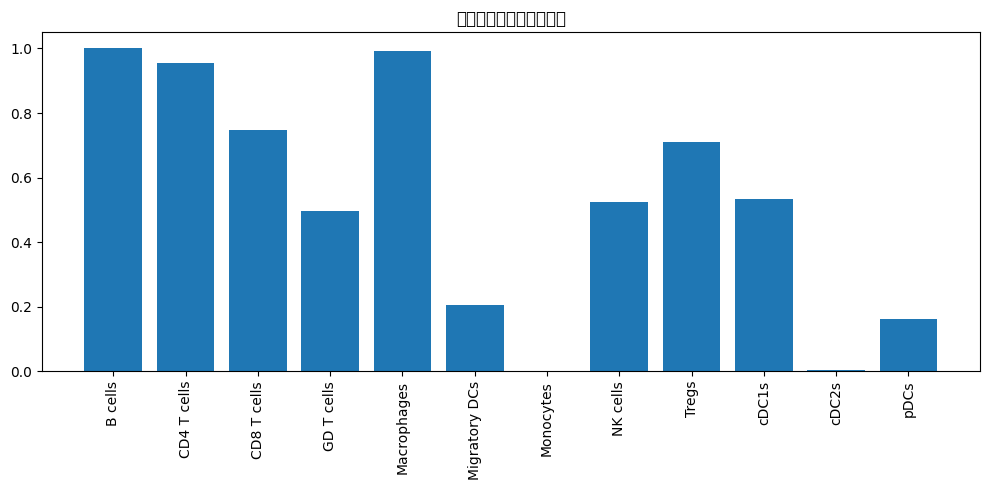

In [30]:
# # 准备数据
# if "counts" in scRNA.layers:
#     X_sc = scRNA.layers["counts"]
# else:
#     X_sc = scRNA.X

# # 稀疏转稠密
# if hasattr(X_sc, "toarray"):
#     X_sc = X_sc.toarray()
# elif hasattr(X_sc, "A"):  # 某些稀疏类型
#     X_sc = X_sc.A

# X_st = torch.tensor(X_st, dtype=torch.float32).to(device)
# # X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
# X_sc = torch.tensor(X_sc, dtype=torch.float32)
# labels = scRNA.obs["cell_types"].astype("category").cat.codes.values
# labels = torch.tensor(labels, dtype=torch.long)

# dataset = TensorDataset(X_sc, labels)
# batch_size = 128
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # 初始化VAE模型
# n_genes = X_sc.shape[1]
# hidden_dims = [512, 256]
# latent_dim = 32
# vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 1. 加载VAE最佳模型参数
vae.load_state_dict(torch.load("best_vae_model.pt", map_location=device))
vae.eval()

# 2. 计算细胞类型不确定性（推断即可）
n_types = len(celltypes)
sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
    vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
)

# 3. 归一化细胞类型不确定性作为GCN的输入
# type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
# print("细胞类型不确定性:", type_unc)

eps = 1e-3
type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
type_unc = type_unc * (1.0 - eps) + eps   # min -> eps, max -> ~1


# 4. 可视化
plt.figure(figsize=(10, 5))
plt.bar(range(len(type_unc)), type_unc)
plt.xticks(range(len(type_unc)), celltypes, rotation=90)
plt.title("每种细胞类型的不确定性")
plt.tight_layout()
plt.show()

vae训练完毕，得到细胞类型水平的不确定性

In [31]:
def get_reference_profile(sc_adata, celltype_key="broad_cell_types", use_layer=None):
    """
    返回 shape: [n_types, n_genes] 的参考表达谱，确保使用与 ST 相同的归一化（传入的 sc_adata 应已归一化并 log1p）。
    """
    celltypes = sc_adata.obs[celltype_key].astype("category").cat.categories
    expr = []
    for ct in celltypes:
        mask = (sc_adata.obs[celltype_key] == ct)
        X = sc_adata[mask].X
        X = X.A if hasattr(X, "A") else X
        expr.append(np.asarray(X).mean(axis=0))
    expr = np.stack(expr, axis=0)  # shape: [n_types, n_genes]
    return expr, list(celltypes), list(sc_adata.var_names)
E, ref_celltypes, ref_genes = get_reference_profile(scRNA, celltype_key="broad_cell_types")
print("E.shape:", E.shape)
assert E.shape[1] == X_st.shape[1], "参考表达谱 E 的基因数量与 ST 输入 X_st 不匹配！"

E.shape: (12, 1888)


In [32]:
# 2. 构建空间邻接关系（edge_index），假设ST_train有空间坐标
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
edges = nbrs.kneighbors_graph(coords).tocoo()
edge_index = np.vstack([edges.row, edges.col])
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

# 3. 初始化GCN模型
n_types = len(celltypes)
gcn = ImprovedUncertaintyGCN(
    in_dim=X_st.shape[1],
    hidden_dim=128,
    n_types=n_types,
    type_uncertainty=type_unc,
    dropout=0.2
).to(device)

# 4. 训练GCN
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 500
# E = ... # 你的参考表达谱（shape: n_types, n_genes），需提前准备好

best_loss = float('inf')
patience = 30
patience_counter = 0

for epoch in range(epochs):
    gcn.train()
    optimizer.zero_grad()
    pred = gcn(X_st, edge_index)  # pred: [n_spots, n_types]
    loss = improved_loss(pred[0], X_st, E, edge_index, type_unc)
    if isinstance(loss, tuple):
        loss = loss[0]
    loss.backward()
    # 检查梯度是否为 0（debug）
    total_grad = 0.0
    for name, param in gcn.named_parameters():
        if param.grad is not None:
            total_grad += param.grad.abs().sum().item()
    # print(f"Epoch {epoch+1}, loss={loss.item():.4f}, total_grad={total_grad:.6f}")
    optimizer.step()

    # 保存最佳模型
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        torch.save(gcn.state_dict(), "best_gcn_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0:
        print(f"GCN Epoch {epoch+1}/{epochs}, loss={loss.item():.4f}, best_loss={best_loss:.4f}, total_grad={total_grad:.6f}")

# 训练结束后加载最佳模型
gcn.load_state_dict(torch.load("best_gcn_model.pt"))

GCN Epoch 10/500, loss=1.3266, best_loss=1.3266, total_grad=18.940199
GCN Epoch 20/500, loss=1.3138, best_loss=1.3132, total_grad=10.248174
GCN Epoch 30/500, loss=1.3076, best_loss=1.3076, total_grad=6.381993
GCN Epoch 40/500, loss=1.3049, best_loss=1.3049, total_grad=6.393059
GCN Epoch 50/500, loss=1.3032, best_loss=1.3032, total_grad=5.634669
GCN Epoch 60/500, loss=1.3023, best_loss=1.3018, total_grad=4.764286
GCN Epoch 70/500, loss=1.3010, best_loss=1.3009, total_grad=3.508345
GCN Epoch 80/500, loss=1.3001, best_loss=1.3001, total_grad=3.637433
GCN Epoch 90/500, loss=1.2992, best_loss=1.2992, total_grad=4.151030
GCN Epoch 100/500, loss=1.2990, best_loss=1.2988, total_grad=4.255009
GCN Epoch 110/500, loss=1.2983, best_loss=1.2983, total_grad=5.955300
GCN Epoch 120/500, loss=1.2979, best_loss=1.2979, total_grad=7.480258
GCN Epoch 130/500, loss=1.2978, best_loss=1.2977, total_grad=6.799843
GCN Epoch 140/500, loss=1.2976, best_loss=1.2974, total_grad=5.659219
GCN Epoch 150/500, loss=1.2

<All keys matched successfully>

In [33]:
gcn.eval()
with torch.no_grad():
    pred = gcn(X_st, edge_index)  # [n_spots, n_types]
    pred = pred[0]

# 2. 用参考表达谱重建spot表达
E_tensor = torch.tensor(E, dtype=torch.float32, device=pred.device)  # [n_types, n_genes]
X_recon = pred @ E_tensor  # [n_spots, n_genes]

# 3. 计算R²
from sklearn.metrics import r2_score
X_true = X_st.cpu().numpy()
X_pred = X_recon.cpu().numpy()
r2 = r2_score(X_true.reshape(-1), X_pred.reshape(-1))
print(f"GCN重建表达的R²: {r2:.4f}")

GCN重建表达的R²: 0.3832


In [34]:
pred[0].sum()

tensor(1.0000, device='cuda:0')

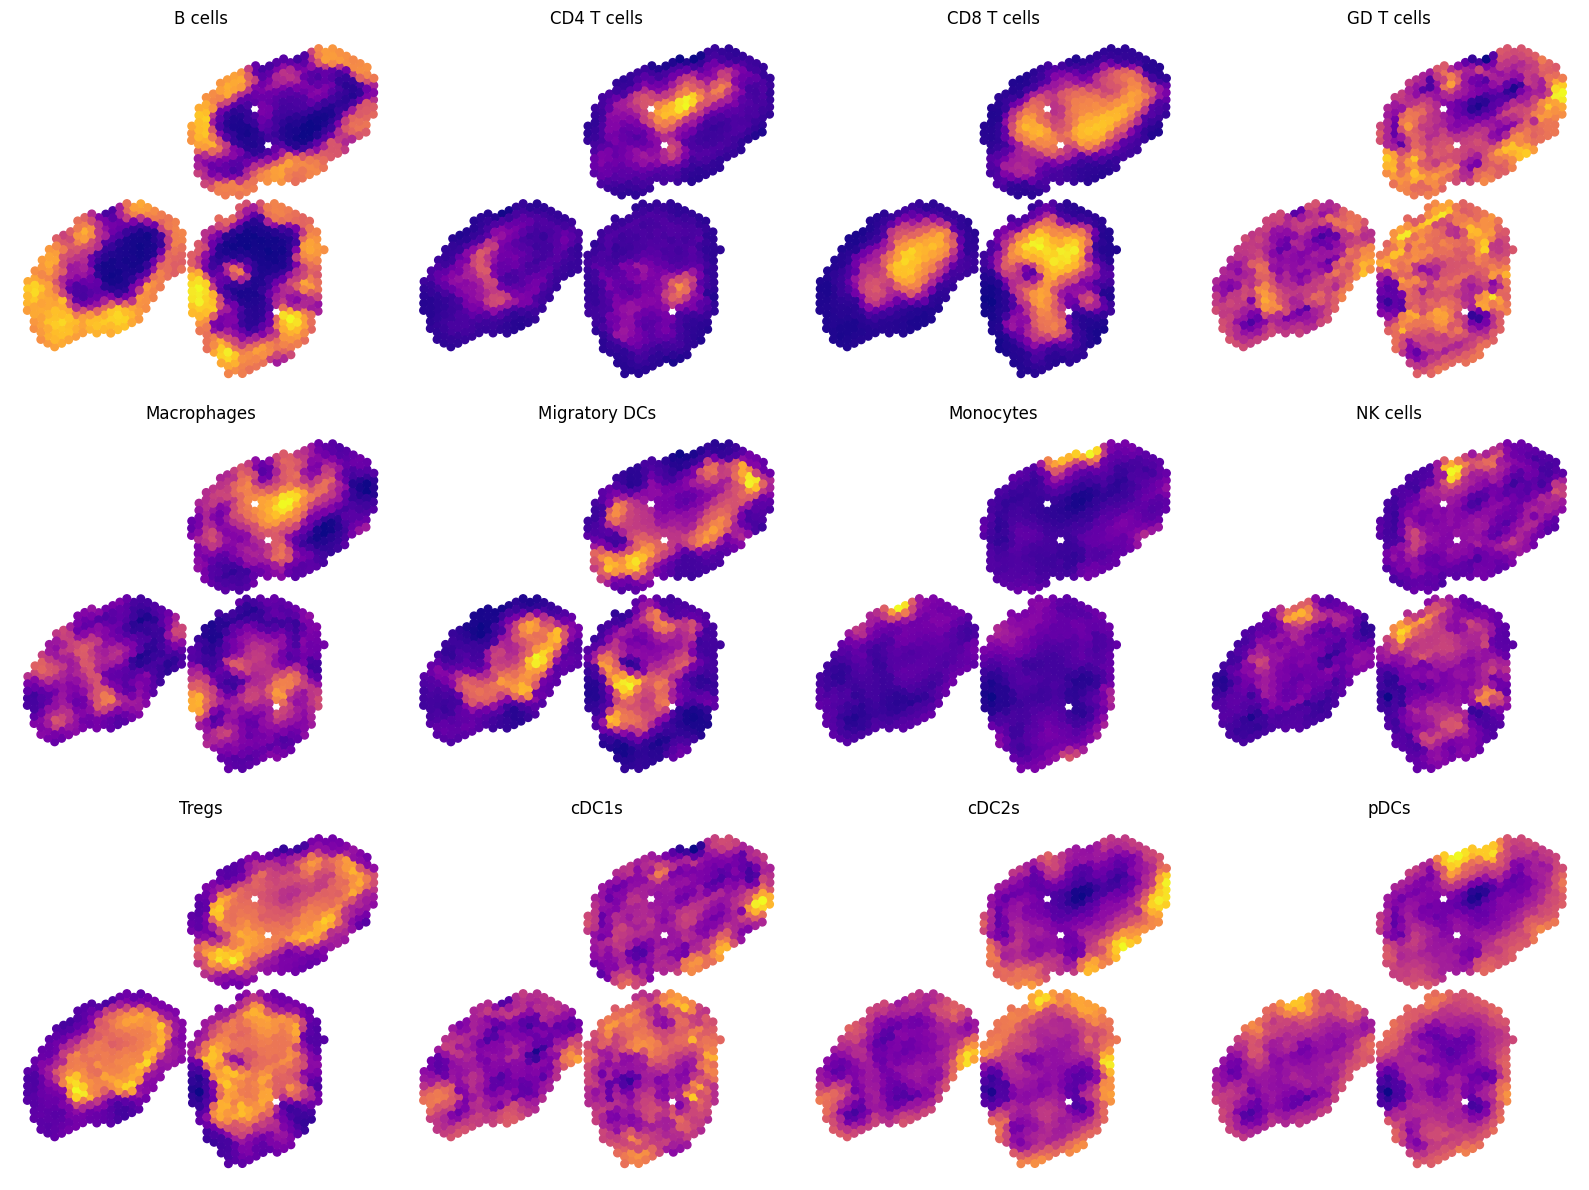

In [35]:
import math

n_types = len(celltypes)
n_cols = 4
n_rows = math.ceil(n_types / n_cols)
pred = pred.cpu().numpy()  # 加在 for 循环前
plt.figure(figsize=(4 * n_cols, 4 * n_rows))
for i, ct in enumerate(celltypes):
    plt.subplot(n_rows, n_cols, i+1)
    # 交换coords的顺序，并翻转y轴
    plt.scatter(coords[:, 1], coords[:, 0], c=pred[:, i], s=30, cmap='plasma')
    plt.title(ct)
    plt.axis('off')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: Us

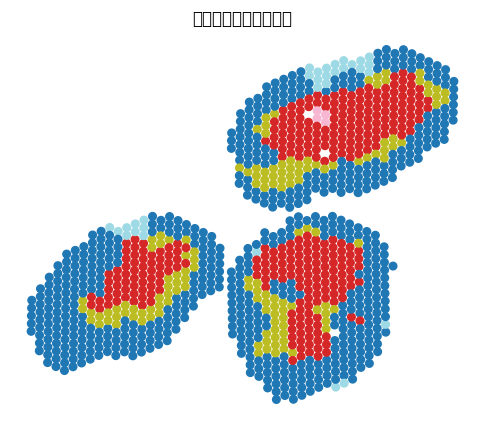

In [36]:
main_type = np.argmax(pred, axis=1)
plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 1], coords[:, 0], c=main_type, s=30, cmap='tab20')
plt.title("主导细胞类型空间分布")
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()

In [37]:
# pred: [n_spots, n_types]，celltypes: 细胞类型名list
for i, ct in enumerate(celltypes):
    ST.obs[ct] = pred[:, i]

In [38]:
celltypes

['B cells',
 'CD4 T cells',
 'CD8 T cells',
 'GD T cells',
 'Macrophages',
 'Migratory DCs',
 'Monocytes',
 'NK cells',
 'Tregs',
 'cDC1s',
 'cDC2s',
 'pDCs']

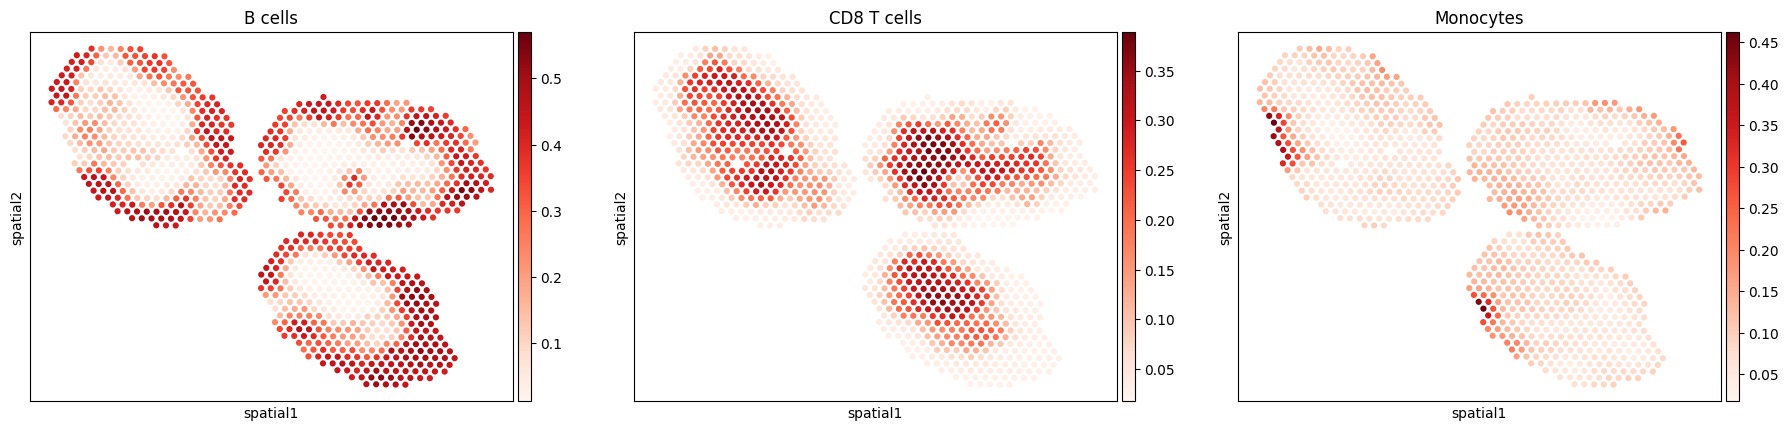

In [39]:
import scanpy as sc
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
# 如果空间坐标在 obsm["spatial"] 或 obsm["location"]，scanpy 会自动识别
sc.pl.embedding(
    ST,
    basis="spatial",  # 或 "location"，看你的 AnnData 里是哪一个
    color=ct_list,  # 画前3个细胞类型
    cmap="Reds",
    s=80
)

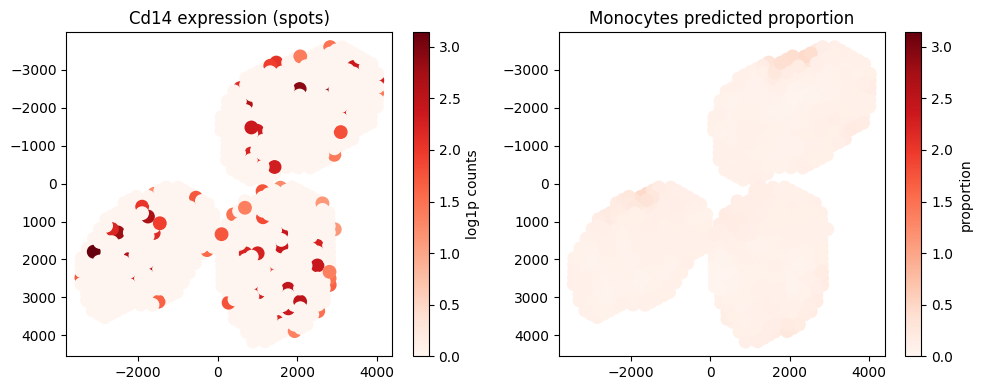

Pearson r between Cd14 and Monocytes prediction: r=0.055, p=6.84e-02


In [49]:
# python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 你要看的基因名（注意大小写/命名，应与 ST.var_names 对应）
gene = "Cd14"   # 或者用 hits 自动匹配到的名字
# monocyte 列在 pred 中的索引（或你写入 ST.obs 的列名）
mono_idx = celltypes.index("Monocytes")  # 如果 celltypes 列表含 Monocytes
mono_pred = pred[:, mono_idx]  # pred 是之前的 numpy 数组 [n_spots, n_types]

# 提取基因表达（spot-level）
Xg = ST[:, gene].X
if hasattr(Xg, "toarray"): Xg = Xg.A
Xg = np.asarray(Xg).ravel()

# 标准化/同一色标范围（可选）
vmin = min(Xg.min(), mono_pred.min())
vmax = max(Xg.max(), mono_pred.max())

# 使用较小点大小绘图（s=30 或 80 视效果），不要乘以 median_nn 的大系数
spot_s = 80

coords = ST.obsm.get("spatial")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(coords[:,1], coords[:,0], c=Xg, s=spot_s, cmap="Reds", vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title(f"{gene} expression (spots)")
plt.colorbar(label="log1p counts")

plt.subplot(1,2,2)
plt.scatter(coords[:,1], coords[:,0], c=mono_pred, s=spot_s, cmap="Reds", vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title("Monocytes predicted proportion")
plt.colorbar(label="proportion")

plt.tight_layout()
plt.show()

# 计算相关性
r, p = pearsonr(Xg, mono_pred)
print(f"Pearson r between {gene} and Monocytes prediction: r={r:.3f}, p={p:.2e}")

In [50]:
# python
# 使用之前的 scRNA（已对齐基因名）
import pandas as pd
ct_key = "broad_cell_types"
gene_name_in_sc = gene  # 若命名不同，用 ref_genes 映射后的名字

# 计算每个细胞类型的均值
df = pd.DataFrame(scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X, columns=scRNA.var_names, index=scRNA.obs_names)
mean_by_ct = df.groupby(scRNA.obs[ct_key])[gene_name_in_sc].mean().sort_values(ascending=False)
print(mean_by_ct)

broad_cell_types
Monocytes        1.184401
cDC2s            0.536064
cDC1s            0.188435
Macrophages      0.050357
pDCs             0.037204
Migratory DCs    0.033597
B cells          0.001114
CD4 T cells      0.000000
CD8 T cells      0.000000
GD T cells       0.000000
NK cells         0.000000
Tregs            0.000000
Name: Cd14, dtype: float32


In [51]:
# python
# 1) 多基因 signature（若单基因弱，用多个 marker 的平均更稳定）
markers = ["CD14","CD68","LYZ","S100A8","S100A9","FCGR3A"]
# 与 ST.var_names 对齐（不区分大小写）
vn = list(ST.var_names)
m_present = [g for g in markers if g in vn or g.capitalize() in vn or g.upper() in vn]
# 尝试大小写变体
m_present = list({next((x for x in (g,g.capitalize(),g.upper()) if x in vn), None):None for g in markers}.keys())
m_present = [m for m in m_present if m is not None]
print("markers used:", m_present)
if m_present:
    Xm = ST[:, m_present].X
    if hasattr(Xm, "toarray"): Xm = Xm.A
    sig = Xm.mean(axis=1)   # signature = 各 marker 的均值
else:
    sig = None

markers used: ['Cd14', 'Cd68']


Pearson r (已有): 0.05516138638355432
Spearman: SpearmanrResult(correlation=0.07988336727184249, pvalue=0.008266713346015142)


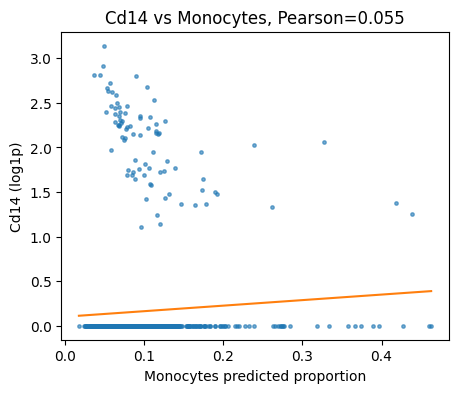

In [52]:
# python
# 2) 计算 Spearman（对非线性/稀疏更稳健）并画散点 + 线性拟合
from scipy.stats import spearmanr, linregress
import matplotlib.pyplot as plt
gene = "Cd14"
Xg = ST[:, gene].X
if hasattr(Xg, "toarray"): Xg = Xg.A
Xg = Xg.ravel()
mono_pred = pred[:, celltypes.index("Monocytes")]  # numpy array
print("Pearson r (已有):", np.corrcoef(Xg, mono_pred)[0,1])
print("Spearman:", spearmanr(Xg, mono_pred))
# 散点图 + 回归线
slope, intercept, r, p, se = linregress(mono_pred, Xg)
plt.figure(figsize=(5,4))
plt.scatter(mono_pred, Xg, s=6, alpha=0.6)
xs = np.linspace(mono_pred.min(), mono_pred.max(), 100)
plt.plot(xs, slope*xs+intercept, color='C1')
plt.xlabel("Monocytes predicted proportion")
plt.ylabel(f"{gene} (log1p)")
plt.title(f"{gene} vs Monocytes, Pearson={np.corrcoef(Xg,mono_pred)[0,1]:.3f}")
plt.show()

In [53]:
# python
# 3) 用参考表达 E 重建该基因的预测表达（pred @ E），比较与真实表达
# 需要 ref_genes (get_reference_profile 返回的 ref_genes) 与 E 已存在
try:
    gi = ref_genes.index(gene)  # 若名字对不上会抛异常
    pred_gene = pred @ E[:, gi]   # pred 是 [n_spots, n_types]，E [n_types, n_genes]
    from scipy.stats import pearsonr
    print("corr(real, pred_reconstructed):", pearsonr(Xg, pred_gene)[0])
except Exception as e:
    print("无法用 ref_genes 定位该基因：", e)

corr(real, pred_reconstructed): 0.055054200378082827


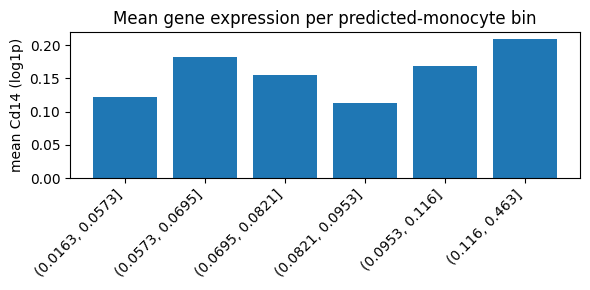

In [55]:
# python
# 4) 分箱分析（把 spots 按预测 monocyte 比例分箱，查看平均 Cd14 表达）
import pandas as pd
df = pd.DataFrame({'Xg':Xg, 'mono':mono_pred})
df['bin'] = pd.qcut(df['mono'], 6, duplicates='drop')
b = df.groupby('bin')['Xg'].mean()
# python
import matplotlib.pyplot as plt
labels = b.index.astype(str)  # 分箱标签
values = b.values
plt.figure(figsize=(6,3))
plt.bar(range(len(values)), values, color='C0')
plt.xticks(range(len(values)), labels, rotation=45, ha='right')
plt.ylabel(f"mean {gene} (log1p)")
plt.title("Mean gene expression per predicted-monocyte bin")
plt.tight_layout()
plt.show()